In [36]:
## import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import scipy.stats as stats
import seaborn as sns
from datetime import datetime
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc, col, count, isnan, lit, sum
from pyspark.sql.functions import col, count, isnan, lit, sum
  
import squarify

from colour import Color
from cartopy.io import shapereader
import geopandas
import cartopy.crs as ccrs

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("id", IntegerType(), False), \
    StructField("titulo", StringType(), True), \
    StructField("descripcion", StringType(), True), \
    StructField("tipodepropiedad", StringType(), True), \
    StructField("direccion", StringType(), True), \
    StructField("ciudad", StringType(), True), \
    StructField("provincia", StringType(), True), \
    StructField("antiguedad", DoubleType(), True), \
    StructField("habitaciones", DoubleType(),  True), \
    StructField("garages", DoubleType(),  True), \
    StructField("banos", DoubleType(),  True), \
    StructField("metroscubiertos", DoubleType(), True), \
    StructField("metrostotales", DoubleType(), True), \
    StructField("idzona", DoubleType(), True), \
    StructField("lat", DoubleType(), True), \
    StructField("lng", DoubleType(), True), \
    StructField("fecha", StringType(),  True), \
    StructField("gimnasio", DoubleType(),  True), \
    StructField("usosmultiples", DoubleType(), True), \
    StructField("piscina", DoubleType(), True), \
    StructField("escuelascercanas", DoubleType(), True), \
    StructField("centroscomercialescercanos", DoubleType(),  True), \
    StructField("precio", DoubleType(),  True)
])

In [4]:
df = sqlContext.read.csv('./train.csv', header=True, schema=data_schema, multiLine = True)

In [5]:
df.show(1)

+------+-----------------+--------------------+---------------+--------------------+-------------+----------------+----------+------------+-------+-----+---------------+-------------+-------+----+----+-------------------+--------+-------------+-------+----------------+--------------------------+---------+
|    id|           titulo|         descripcion|tipodepropiedad|           direccion|       ciudad|       provincia|antiguedad|habitaciones|garages|banos|metroscubiertos|metrostotales| idzona| lat| lng|              fecha|gimnasio|usosmultiples|piscina|escuelascercanas|centroscomercialescercanos|   precio|
+------+-----------------+--------------------+---------------+--------------------+-------------+----------------+----------+------------+-------+-----+---------------+-------------+-------+----+----+-------------------+--------+-------------+-------+----------------+--------------------------+---------+
|254099|depto. tipo a-402|depto. interior d...|    Apartamento|Avenida Division

In [6]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- titulo: string (nullable = true)
 |-- descripcion: string (nullable = true)
 |-- tipodepropiedad: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- provincia: string (nullable = true)
 |-- antiguedad: double (nullable = true)
 |-- habitaciones: double (nullable = true)
 |-- garages: double (nullable = true)
 |-- banos: double (nullable = true)
 |-- metroscubiertos: double (nullable = true)
 |-- metrostotales: double (nullable = true)
 |-- idzona: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- fecha: string (nullable = true)
 |-- gimnasio: double (nullable = true)
 |-- usosmultiples: double (nullable = true)
 |-- piscina: double (nullable = true)
 |-- escuelascercanas: double (nullable = true)
 |-- centroscomercialescercanos: double (nullable = true)
 |-- precio: double (nullable = true)



In [7]:
#Load the data
trainDF = pd.read_csv('./train.csv')
train = trainDF.sample(1000)

In [8]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng                           116512 non-null float64
fecha                         240

In [9]:
train.head(5)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
56719,218730,casa en venta patrimonio puebla,conjunto cerrado de 5 casas - 90 m2 de terreno...,Casa,COLONIA PATRIMONIO,Puebla,Puebla,5.0,3.0,1.0,...,78733.0,NaN,NaN,2015-02-13 00:00:00,0.0,0.0,0.0,0.0,1.0,780000.0
6254,284134,hermosa casa cabsh0165,"ven a conocer esta acogedora casa, el hogar de...",Casa en condominio,"Independencia, LA LOMA II",Toluca,Edo. de México,5.0,3.0,2.0,...,52137.0,19.241810,-99.642147,2014-06-08 00:00:00,0.0,0.0,0.0,1.0,1.0,1510000.0
216294,89567,unico garden house 328 const + 108 jardin. hac...,"precioso garden house, 328 m construídos en do...",Apartamento,Hacienda El Ciervo 11-1D,Huixquilucan,Edo. de México,10.0,3.0,NaN,...,55519.0,19.390202,-99.286596,2015-09-28 00:00:00,1.0,1.0,1.0,1.0,1.0,7900000.0
26441,265097,excelente departamento,"departamento en venta, con dos recamaras con c...",Apartamento,CALZADA DEL HUESO,Coyoacán,Distrito Federal,10.0,2.0,1.0,...,23729.0,NaN,NaN,2016-05-31 00:00:00,0.0,0.0,0.0,1.0,1.0,1100000.0
116057,26386,"casa cerca de centro, calle jp silva, miguel a...","casa muy céntrica, a una cuadra de la av. alle...",Casa,J P Silva,Veracruz,Veracruz,50.0,4.0,NaN,...,107965.0,19.205939,-96.153836,2015-07-01 00:00:00,0.0,0.0,0.0,1.0,1.0,950000.0


$\text{The most important column of the dataset it the sale price. However a broad look at the data is often needed.}$

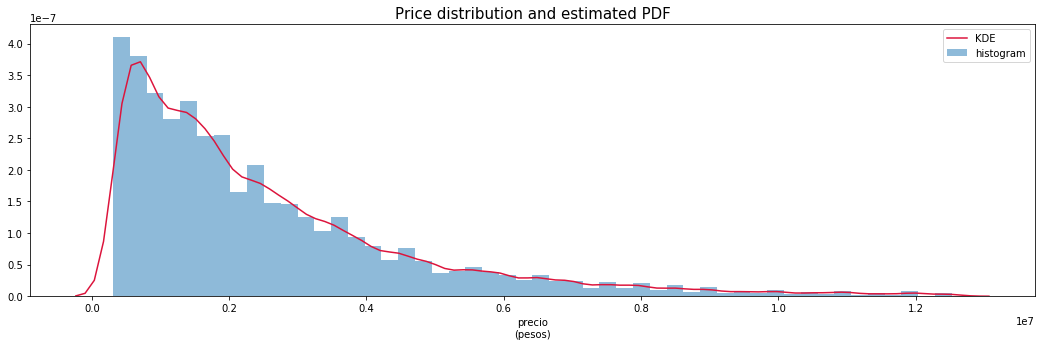

+-------+------------------+
|summary|            precio|
+-------+------------------+
|  count|            240000|
|   mean|2530838.3458958333|
| stddev|2152551.7976219207|
|    min|          310000.0|
|    max|          1.2525E7|
+-------+------------------+

The skewness in Sale price is : 1.70201
The Kurtosis in Sale price is : 3.23109


In [10]:
plt.figure(figsize = [18,5])
#sns.distplot(train['precio'],label ='density estimation')
sns.distplot(trainDF['precio'],kde_kws={"color": "crimson", "label": "KDE"},
             hist_kws={"linewidth": 3, "alpha": 0.5,"label" : "histogram"})
plt.title('Price distribution and estimated PDF', fontsize = 15)
plt.xlabel('precio\n(pesos)')
plt.legend()
plt.show()
df.select('precio').describe().show()

print('The skewness in Sale price is : %.5f'%trainDF['precio'].skew())
print('The Kurtosis in Sale price is : %.5f'%trainDF['precio'].kurt())

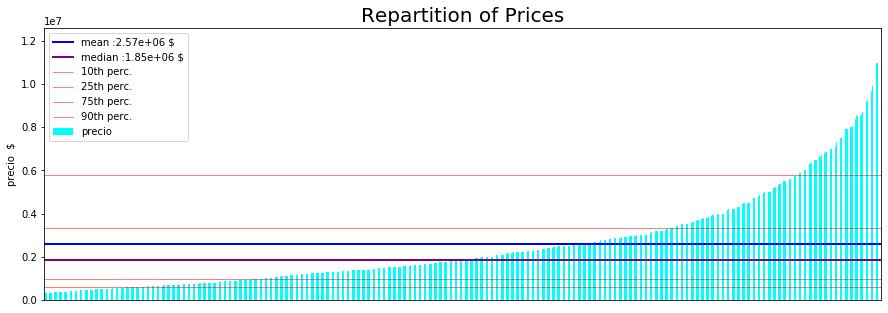

+-------+------------------+
|summary|            precio|
+-------+------------------+
|  count|            240000|
|   mean|2530838.3458958333|
| stddev|2152551.7976219207|
|    min|          310000.0|
|    max|          1.2525E7|
+-------+------------------+

The skewness in Sale price is : 1.70201
The Kurtosis in Sale price is : 3.23109


In [11]:
fig, ax = plt.subplots(figsize=[15,5])

train['precio'].sort_values().plot(kind='bar', ax = ax, xticks=None, cmap='cool')
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)

plt.axhline(train['precio'].mean(),c = 'b', linewidth = 2, label = "mean :" + "%.2e"%train['precio'].mean()+ " $")
plt.axhline(train['precio'].median(),c = 'purple', linewidth = 2, label = "median :" + "%.2e"%train['precio'].median()+ " $")

for i, quantile in enumerate([.1, 0.25, .75, .9]):
    ax.axhline(train['precio'].quantile(quantile), label='%.0fth perc.' % (quantile*100), color = 'r', linewidth = 0.5)
    
plt.ylabel("precio  $")
plt.legend()
plt.title('Repartition of Prices',fontsize = 20)
plt.show()
df.select('precio').describe().show()
print('The skewness in Sale price is : %.5f'%trainDF['precio'].skew())
print('The Kurtosis in Sale price is : %.5f'%trainDF['precio'].kurt())

$\text{Let's see the impact of each columns and their relations.}$

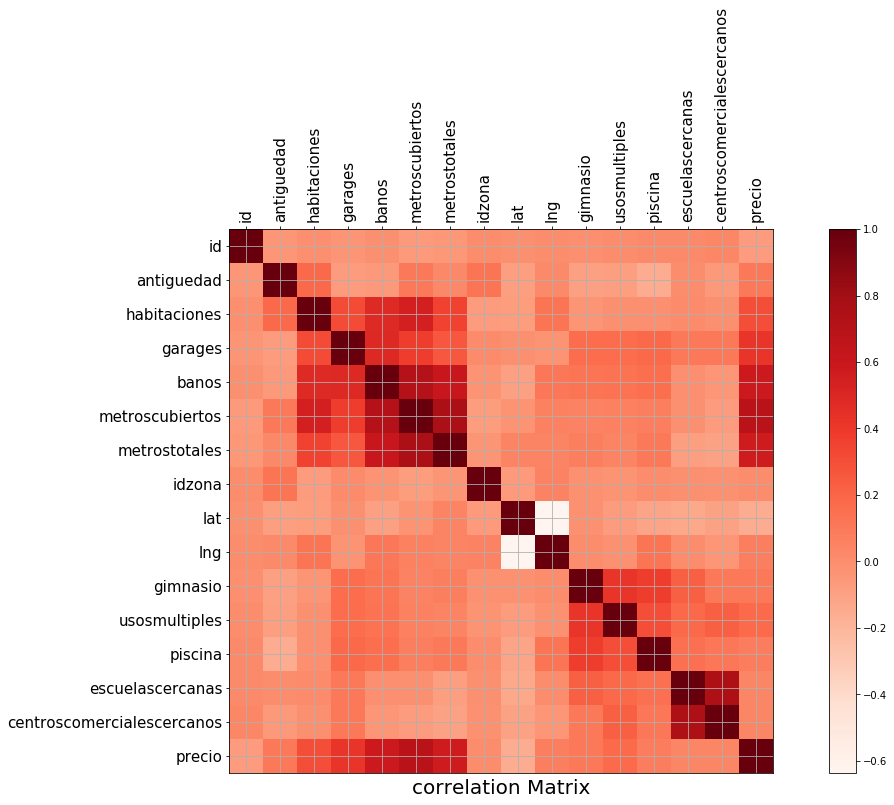

In [12]:
cor = train.corr()
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))


fig, ax = plt.subplots(figsize=[20,10])

plt.title("correlation Matrix", fontsize = 20, y=-0.05)
image = ax.imshow(cor, cmap = 'Reds')#'Greys','hsv')

plt.xticks(np.arange(len(cor.columns)),cor.columns, rotation = 'vertical', fontsize = 15)
ax.xaxis.tick_top()
plt.yticks(np.arange(len(cor.columns)),cor.columns, rotation = 'horizontal', fontsize = 15)
fig.colorbar(image, ax=ax)
plt.rcParams['grid.color'] = "w"
plt.grid()
plt.show()

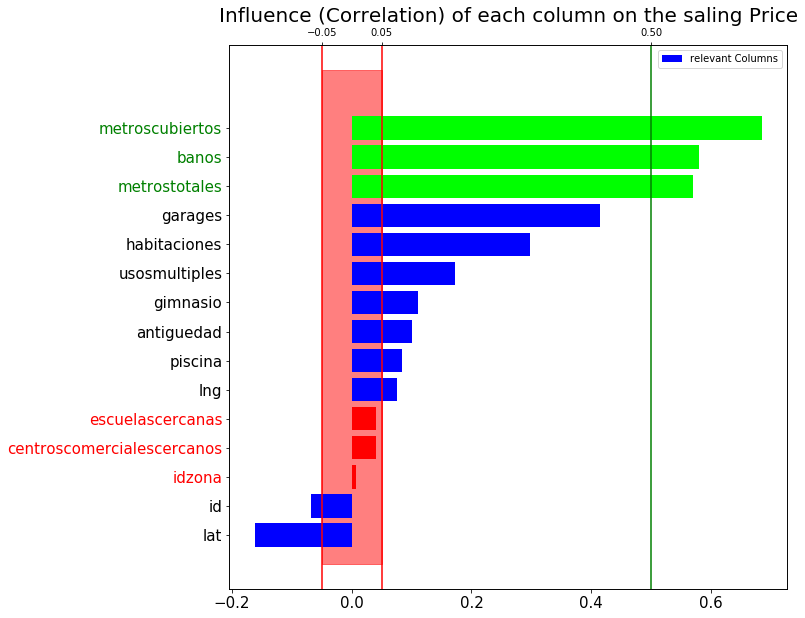

In [13]:
#order the correlations and their associated column
minCorrValue = 0.05
goodCorrValue = 0.5

corrOrdered = list(upper['precio'].copy().sort_values())
numNan = upper['precio'].isnull().sum()
colOrdered = [upper.columns[list(upper['precio']).index(x)] for x in corrOrdered[:-numNan]]

# We have colOrdered, corrOrdered, numNan, lowCorrelatedColumns

lowCorrelatedColumns, highCorrelatedColumns = [], []

#get the high and low correlated columns + color
colorList= ['b']*len(colOrdered)
for x in corrOrdered:
    if abs(x) in [x for x in list(upper['precio'].abs()) if x<minCorrValue]:
        colorList[corrOrdered.index(x)] = 'r'                    #undecoralated columns are red
        lowCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
    if abs(x) in [x for x in list(upper['precio'].abs()) if x>goodCorrValue]:
        colorList[corrOrdered.index(x)] = 'lime'                    #undecoralated columns are red
        highCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
                        
            
plt.figure(figsize=[10,10])
plt.barh(colOrdered,corrOrdered[:-numNan], color=colorList)
plt.title("Influence (Correlation) of each column on the saling Price", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend( ['relevant Columns','good'])
plt.axvline(x= minCorrValue, c='r')
plt.fill_between([-minCorrValue,minCorrValue], [len(upper),len(upper)],[-1,-1], alpha = 0.5, color = 'red')
plt.axvline(x= -minCorrValue, c='r')
plt.axvline(x= goodCorrValue, c='g')
ax = plt.gca()
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-minCorrValue,minCorrValue,goodCorrValue])

#color the yticks
for x in lowCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("red")
for x in highCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("green")

plt.show()
#print("Low correlatedColumns", lowCorrelatedColumns)

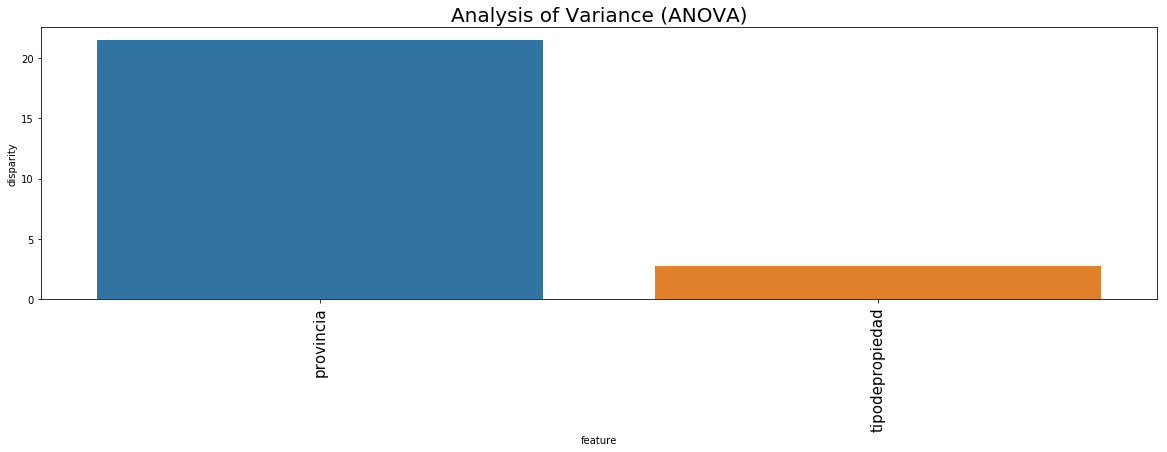

In [14]:
qualitative = train.select_dtypes('object').columns

qualitativeImportant = ['tipodepropiedad','provincia']
qualitative = qualitativeImportant
plt.figure(figsize = [20,5])
anova = pd.DataFrame(columns = ['feature','pvalue'])
anova['feature'] = qualitative
for col in qualitative: #for each qualitative column we get the pvalues
    samples = []
    for elt in train[col].unique():
        samples.append(train['precio'][train[col] == elt].values)
    a = stats.f_oneway(*samples)
    anova['pvalue'][anova['feature']==col] = a.pvalue
    
#sort and cast
anova = anova.sort_values('pvalue')
anova['pvalue'] = anova['pvalue'].astype('float')
#transform for better visualisation and plot
anova['disparity'] = np.log(1./anova['pvalue'].values)
sns.barplot(data=anova, x='feature', y='disparity')
x=plt.xticks(rotation=90, fontsize = 15)
plt.title('Analysis of Variance (ANOVA)', fontsize = 20)
plt.show()

---
### $\textbf{Now let's dig into this and examine closely the impact of factors on the saling price.}$
---

$\text{Starting with the impact of time on data}$

In [15]:
dayByMonth = [31,27,31,30,31,30,31,31,30,31,30,31]
daysList = ['mon','tue','wed','thu','fri','sat','sun']
#format date columns
#cast to datetime type
trainDF['Date'] = trainDF['fecha'].apply(func = (lambda x :(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))))
trainDF['year'] = trainDF['Date'].apply(func = (lambda t : int(t.year)))
trainDF['dayOfYear'] = trainDF['Date'].apply(func = (lambda t : int(t.day+np.sum(dayByMonth[:t.month-1]))))
trainDF['dayOfweek'] = trainDF['Date'].apply(func = (lambda t : t.weekday()))

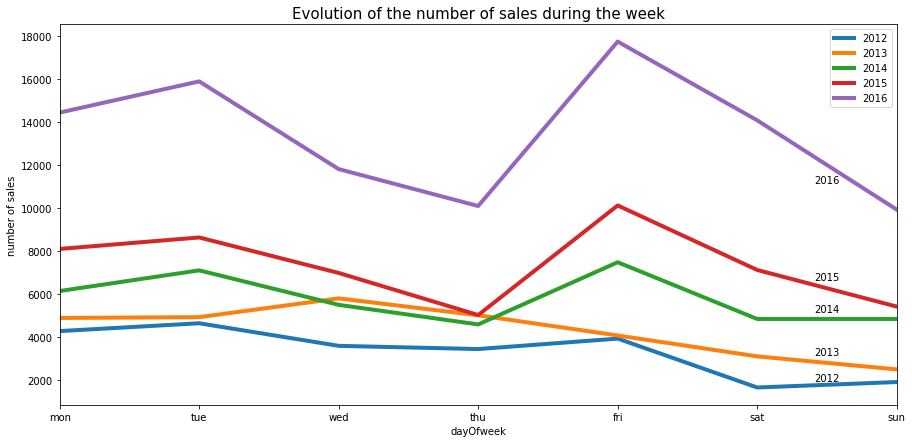

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
#res = trainDF[['year','dayOfweek','precio']].groupby(['year', 'dayOfweek']).agg(['count'])
trainDF.groupby(['dayOfweek','year']).count()['precio'].unstack().plot(ax=ax, label = daysList,linewidth=4)
plt.ylabel('number of sales')
plt.xticks(np.arange(7),daysList)
#fancy annotations
plt.annotate('2016', (5.5,10700), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2015', (5.5,6200), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2014', (5.5,4700), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2013', (5.5,2700), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2012', (5.5,1500), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()
plt.title('Evolution of the number of sales during the week', fontsize = 15)
plt.grid(True)
plt.rc('grid', linestyle="-", color='black', alpha = 0.2)
plt.show()

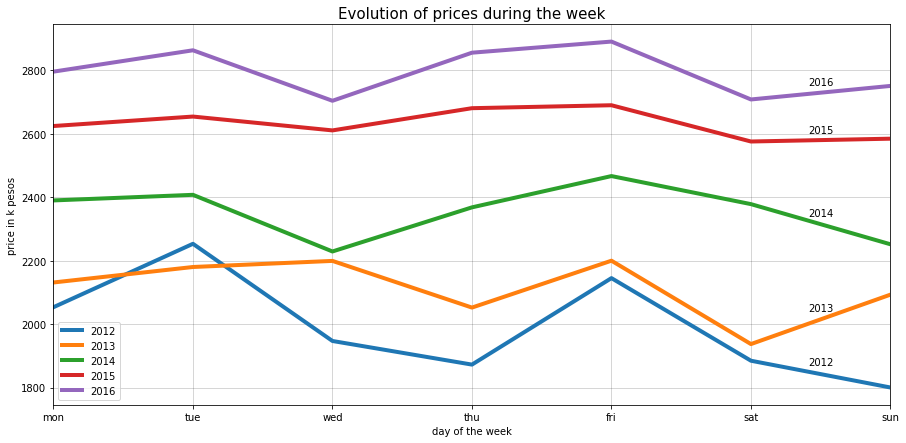

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
temp = trainDF.groupby(['dayOfweek','year']).mean()['precio']/10**3
temp.unstack().plot(ax=ax, label = daysList,linewidth=4)
plt.xticks(np.arange(7),daysList)
#fancy annotations
plt.annotate('2016', (5.5,2720), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2015', (5.5,2570), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2014', (5.5,2310), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2013', (5.5,2010), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2012', (5.5,1840), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()
plt.ylabel('price in k pesos')
plt.xlabel('day of the week')
plt.title('Evolution of prices during the week', fontsize = 15)
plt.grid(True)
plt.rc('grid', linestyle="-", color='black', alpha = 0.2)
plt.show()

$\text{Prices by day of the year and month}$

In [18]:
#Mean price for every day of the year
sum = trainDF.groupby('dayOfYear').sum().sort_values('dayOfYear', ascending=True).precio
count = trainDF.groupby('dayOfYear').count().sort_values('dayOfYear', ascending=True).precio
res = sum/count
#colorList changing each months
colorList = ['b','g','r','c','m','y','b','g','r','c','m','k']
#separte into months
resList = [[]]*12
i,k = 0,0
for x in dayByMonth:
    resList[i] = res.iloc[k:k+x]
    i += 1
    k += x

In [19]:
res = trainDF.groupby('dayOfYear').mean().sort_values('dayOfYear', ascending=True).precio
resultList = [[]]*12
i = 0
k = 0
for x in dayByMonth:
    resultList[k] = res.iloc[i:i+x].values
    k+=1
    i+=x

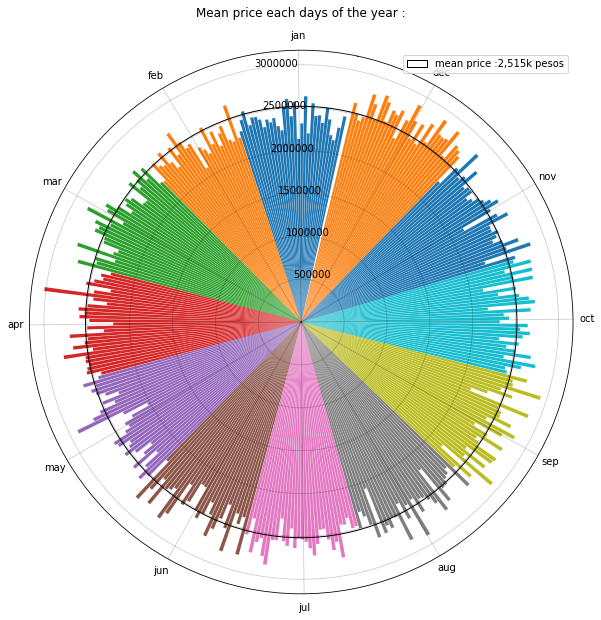

The best day to buy a property was the 13 May
The worst day to buy a property was the 07 April


In [20]:
monthList = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

#plot, round layout
plt.figure(figsize=[10,10])
ax = plt.subplot(111, polar=True)
ax.set_xticks((np.arange(12)*(2*np.pi)/12)+0.22)#set xticks location to be corresponding with the months
ax.set_xticklabels(monthList)
ax.set_theta_zero_location('N',-12)
plt.title("Mean price each days of the year :")
offset=0

circle = plt.Circle((0, 0), np.mean(res), transform=ax.transData._b, color="black",
                    alpha=1, fill = False,label='mean')
ax.add_artist(circle)

ax.legend([circle], ['mean price :'+"{:,d}".format(int(np.mean(res)/10**3))+'k pesos'])
for i in range(12):
    newOffset = offset+len(resultList[i])
    theta = np.linspace((2*np.pi)*offset/365, (2*np.pi)*newOffset/365, len(resultList[i]), endpoint=False)
    offset = newOffset
    ax.bar(theta, resultList[i], width = np.ones(len(resultList[i]))*0.015)
plt.show()

#print valuable information
print('The best day to buy a property was the',datetime.strptime('2014 '+
                         str(res[res.values == min(res)].index[0]), '%Y %j').strftime('%d %B'))
print('The worst day to buy a property was the',datetime.strptime('2014 '+
                         str(res[res.values == max(res)].index[0]), '%Y %j').strftime('%d %B'))

---

#### $\textbf{Let's now tackle the impact of location on the saling price:}$

$\text{-by city}\\\text{-by geographical zone}\\\text{-by lat/lnt location}$

---


$\text{Prices by cities}$

In [21]:
topSellingCities = df.groupby('ciudad').count().orderBy('count', ascending=0).collect()[:15]
topVendingCities = df.groupby('ciudad').mean('precio').orderBy('avg(precio)', ascending=0).collect()[:15]

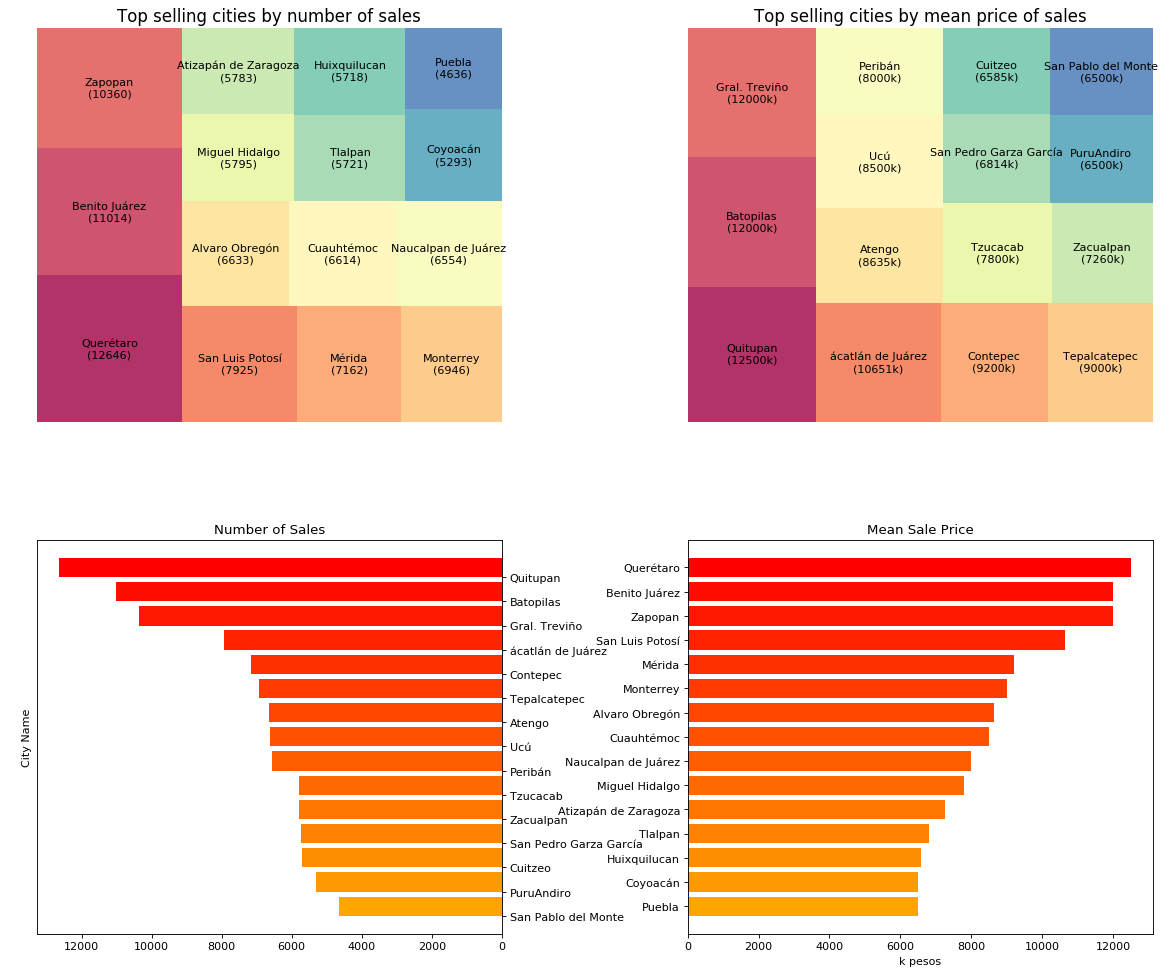

In [22]:
labelsNumber = [str(x[0])+'\n('+str(x[1])+')' for x in topSellingCities]
sizesNumber = [x[1] for x in topSellingCities]
labelsPrice = [str(x[0])+'\n('+str(int(x[1]/1000))+'k)' for x in topVendingCities]
sizesPrice = [x[1] for x in topVendingCities]

#colors for The area plots
colorsPrice = [plt.cm.Spectral(i/float(len(labelsPrice))) for i in range(len(labelsPrice))]
colorsNumber = [plt.cm.Spectral(i/float(len(labelsNumber))) for i in range(len(labelsNumber))]

#colors for the barPlot
red = Color("orange")
colors = list(red.range_to(Color("red"),len(sizesPrice)))
colors = [color.rgb for color in colors]


# Draw Plot
plt.subplots(nrows = 2, ncols = 3, figsize=(18, 15), dpi = 80)


grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)


plt.subplot(grid[0, 0])
squarify.plot(sizes=sizesNumber, label=labelsNumber, color=colorsNumber, alpha=.8)
plt.title('Top selling cities by number of sales', fontsize = 15)
plt.axis('off')
plt.xlabel('price in pesos')

plt.subplot(grid[0, 1])    
squarify.plot(sizes=sizesPrice, label=labelsPrice, color=colorsPrice, alpha=.8)
plt.title('Top selling cities by mean price of sales', fontsize = 15)
plt.axis('off')


ax = plt.subplot(grid[1:, 0])    
plt.title('Number of Sales')
topVendingCities.reverse(), sizesNumber.reverse()
plt.barh([str(x[0])for x in topVendingCities],sizesNumber,align = 'edge',color=colors)
ax.invert_xaxis()
plt.ylabel('City Name')
ax.yaxis.tick_right()

plt.subplot(grid[1:, 1])    
plt.title('Mean Sale Price')
topSellingCities.reverse(),sizesPrice.reverse()
plt.barh([str(x[0])for x in topSellingCities],[int(x/10**3) for x in sizesPrice], color=colors)#["%.2f" % int(x/10**5) for x in sizesPrice])
plt.xlabel('k pesos')
# Decorate

plt.show()

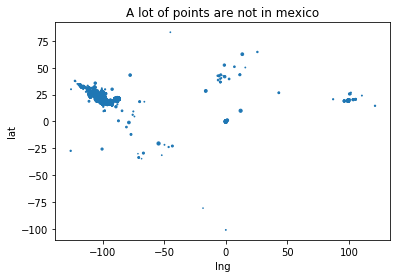

In [23]:
# just to show the problem in our data
mapTrainDF = trainDF[['lat','lng','precio']].dropna()
mapTrainDF.plot(kind="scatter", x="lng", y="lat", s=mapTrainDF['precio']/10**6,
                title ='A lot of points are not in mexico')
plt.show()

In [24]:
mapTrainDF = trainDF[['lat','lng','precio','ciudad','idzona']].dropna()
mapTrainDF.head(2)

,lat,lng,precio,ciudad,idzona
1,19.310205,-99.227655,3600000.0,La Magdalena Contreras,24514.0
3,19.301890,-99.688015,650000.0,Zinacantepec,53666.0


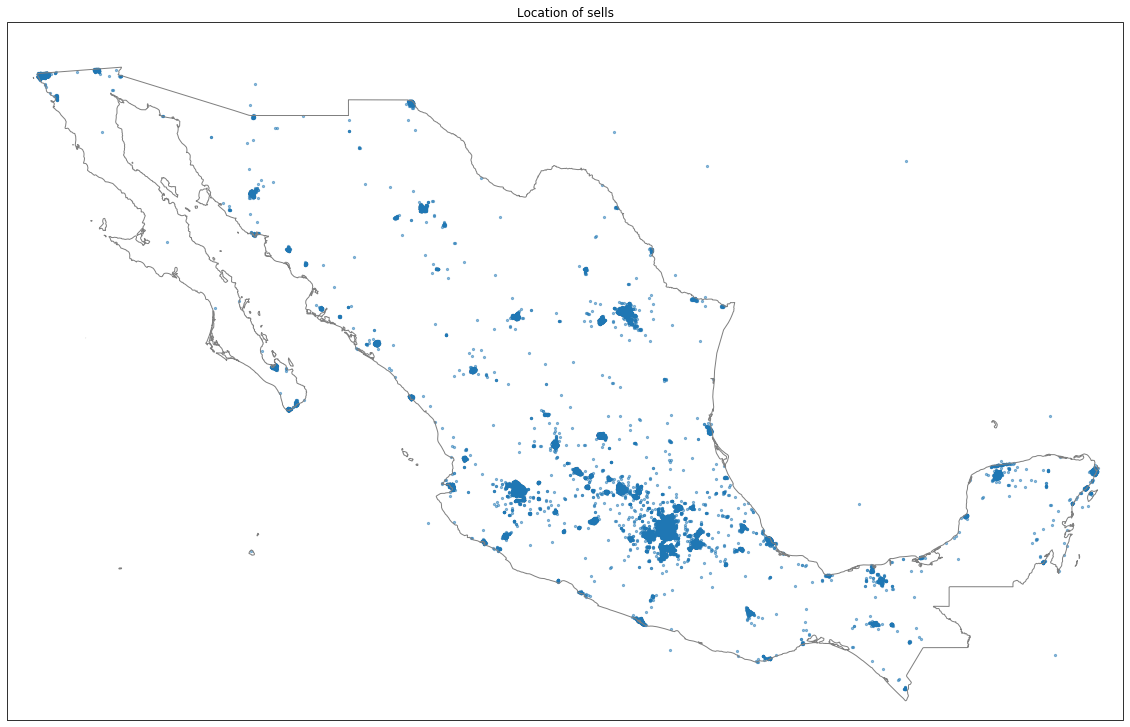

In [25]:
plt.figure(figsize = [20,15])
# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
geodf = geopandas.read_file(shpfilename)

# read the Mexican borders
poly = geodf.loc[geodf['ADMIN'] == 'Mexico']['geometry'].values[0]

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', 
                  edgecolor='0.5')
#plot the points we have
mapTrainDF.plot(kind="scatter", x="lng", y="lat",marker ='.', ax=ax, alpha=0.5,transform=ccrs.PlateCarree())
plt.title('Location of sells')
#Set the map on mexico's location

ax.set_extent([-118, -86, 14, 34], crs=ccrs.PlateCarree())

In [26]:
#create a df for map data
mapTrainDF = mapTrainDF[['lat','lng','precio']]
#filter out the outliers -> not in Mexico
mapTrainDF = mapTrainDF[(np.abs(stats.zscore(mapTrainDF)) < 12).all(axis=1)]

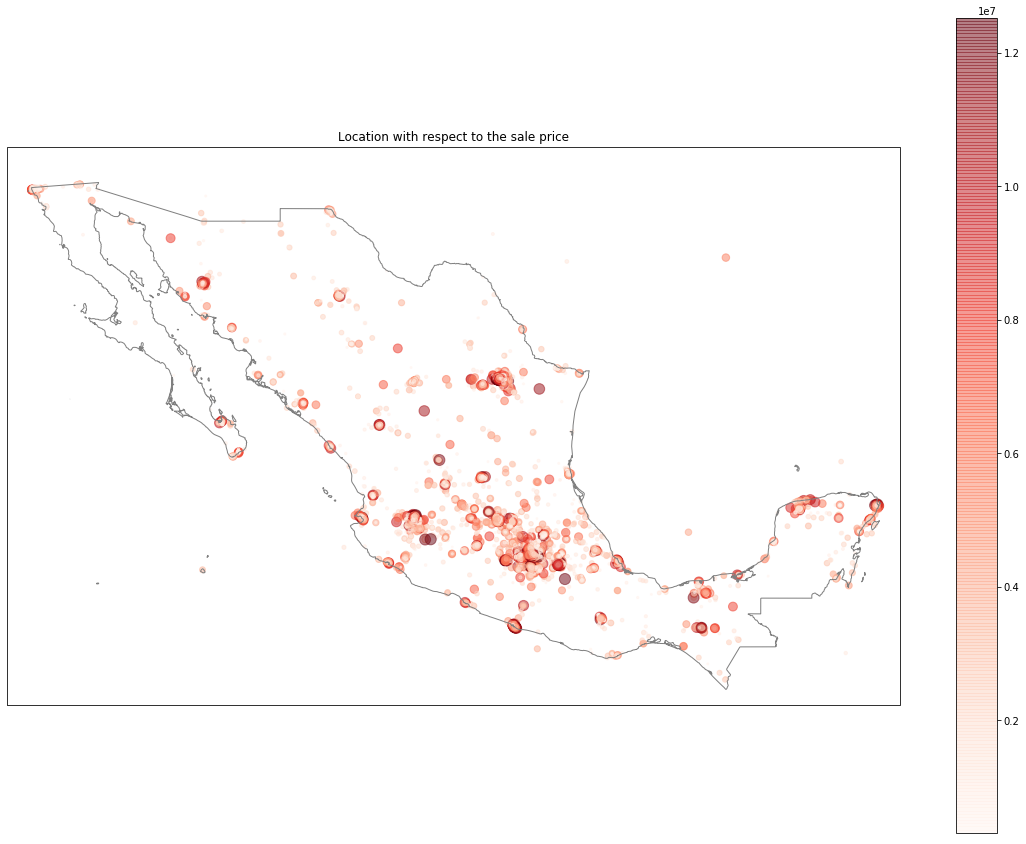

In [27]:
plt.figure(figsize = [20,15])
# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
geodf = geopandas.read_file(shpfilename)

# read the Mexican borders
poly = geodf.loc[geodf['ADMIN'] == 'Mexico']['geometry'].values[0]

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', 
                  edgecolor='0.5')
#plot the points we have
mapTrainDF.plot(kind="scatter", x="lng", y="lat", s=mapTrainDF['precio']/10**5,
                 c = mapTrainDF['precio'], cmap = "Reds", colorbar=True,ax=ax, alpha =0.5)
plt.title('Location with respect to the sale price')
#Set the map on mexico's location

ax.set_extent([-118, -86, 14, 34], crs=ccrs.PlateCarree())

---
### $\textbf{Nan Values}$
---
$\text{When looking at data it is important to keep in mind that it can contain missing values.}
\\\text{Dealing with those is paramount in order to work with out data.}$

                 numNanVal
titulo                5387
descripcion           1619
tipodepropiedad         46
direccion            53072
ciudad                 372
provincia              155
antiguedad           43555
habitaciones         22471
garages              37765
banos                26221
metroscubiertos      17400
metrostotales        51467
idzona               28621
lat                 123488
lng                 123488


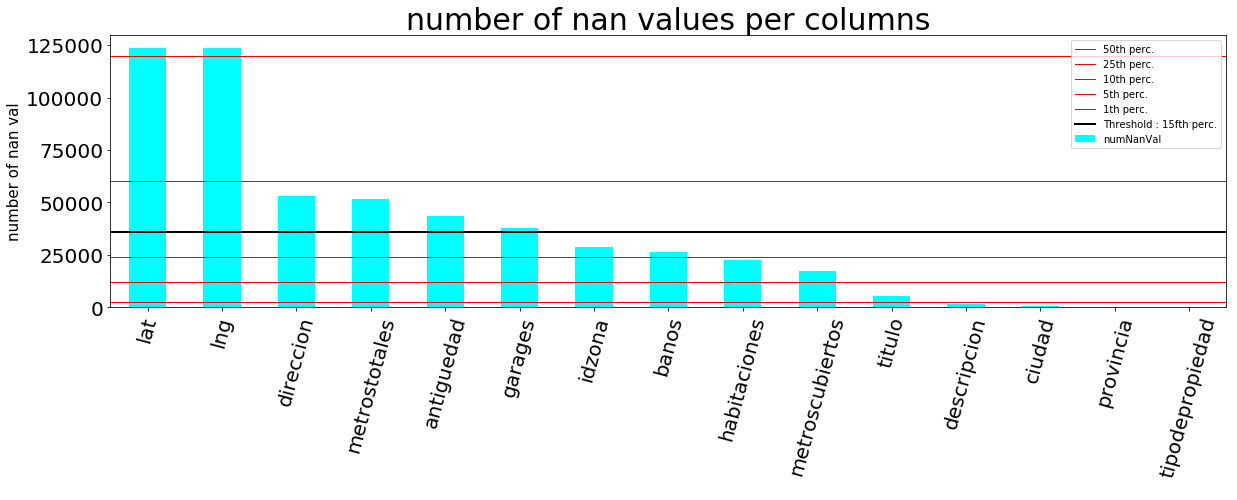

In [37]:
def count_not_null(c, nan_as_null=False):
    """Use conversion between boolean and integer
    - False -> 0
    - True -> 1
    """
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)

  
#dealing with missing values:
#where are they ?
fig, ax = plt.subplots(figsize=[20,5])


#total number of values
numVal = df.count()
nanValDF = df.agg(*[count_not_null(c) for c in df.columns]).toPandas().transpose()
nanValDF.columns = ['numNanVal']
#rectify the count
nanValDF['numNanVal'] = -1*nanValDF['numNanVal']+numVal
#filter the 0 values
nanValDF = nanValDF[nanValDF['numNanVal']>0]

print(nanValDF)
nanValDF.sort_values(by='numNanVal', ascending = False).plot(kind='bar', ax = ax, cmap='cool')
plt.tick_params(labelsize=20)
plt.ylabel("number of nan val", fontsize=15)
plt.xlabel(" ")
plt.title("number of nan values per columns", fontsize=30)


for i, quantile in enumerate([.01, 0.05, .1, .25, .5][::-1]):
    ax.axhline(numVal*quantile,c='r', linewidth=1, label='%.0fth perc.' %(quantile*100))
ax.axhline(numVal*0.15,c='black', linewidth=2, label='Threshold : 15fth perc.')

    
plt.legend()
plt.xticks(rotation = 75)
plt.show()

---
### $\textbf{Normalization of the data}$

---
$\text{Most of the business analytics frameworks are tailor-made for working with Normally distributed data sets.}\\\text{Hence we should transform our data to follow that distribution if possible.}$

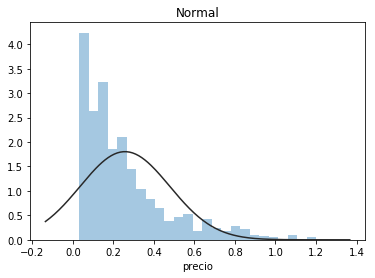

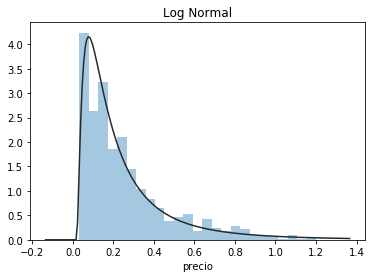

In [38]:
y = train['precio']/10**7
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)
plt.show()

In [39]:
#separate features in quantitative and qualitative for a separate analysis
quantitative = list(train.select_dtypes('number').columns)
quantitative.remove('id')
qualitative = train.select_dtypes('object').columns.values
qualitativeImportant = ['tipodepropiedad','provincia']

In [40]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


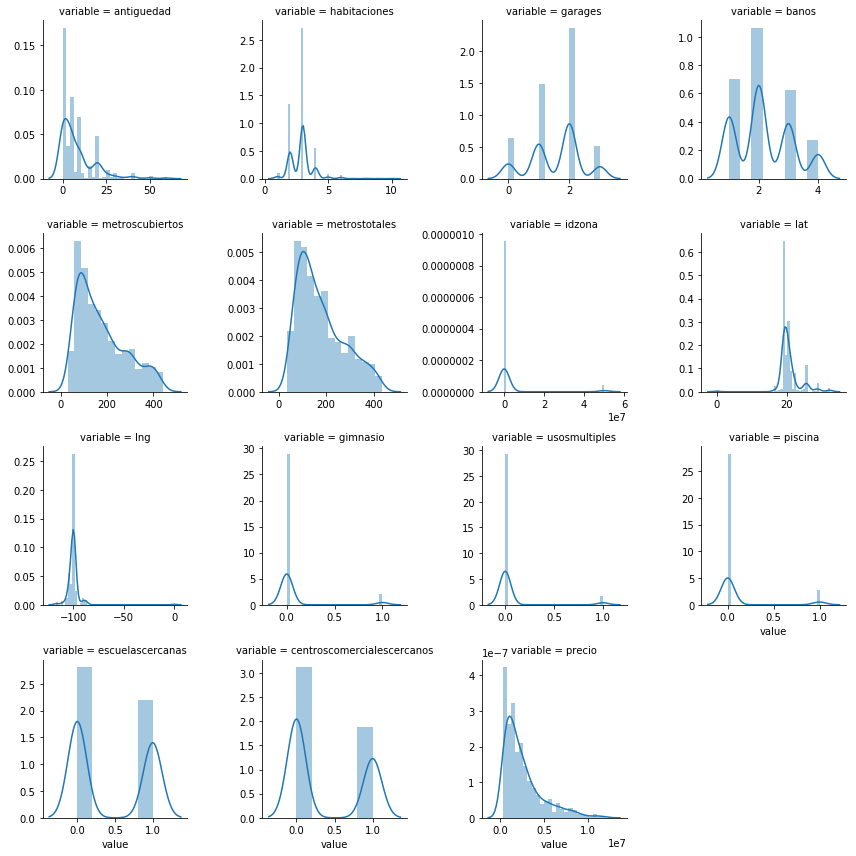

In [41]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

$\text{Let's now have a look at the importance of the qualitative variable}$

In [42]:
anova = pd.DataFrame(columns = ['feature','pvalue'])
anova['feature'] = qualitativeImportant
for col in qualitativeImportant: #for each qualitative column we get the pvalues
    samples = []
    for elt in train[col].unique():
        samples.append(train['precio'][train[col] == elt].values)
    a = stats.f_oneway(*samples)
    anova['pvalue'][anova['feature']==col] = a.pvalue
    
#sort and cast
anova = anova.sort_values('pvalue')
anova['pvalue'] = anova['pvalue'].astype('float')
#transform for better visualisation and plot
anova['disparity'] = np.log(1./anova['pvalue'].values)

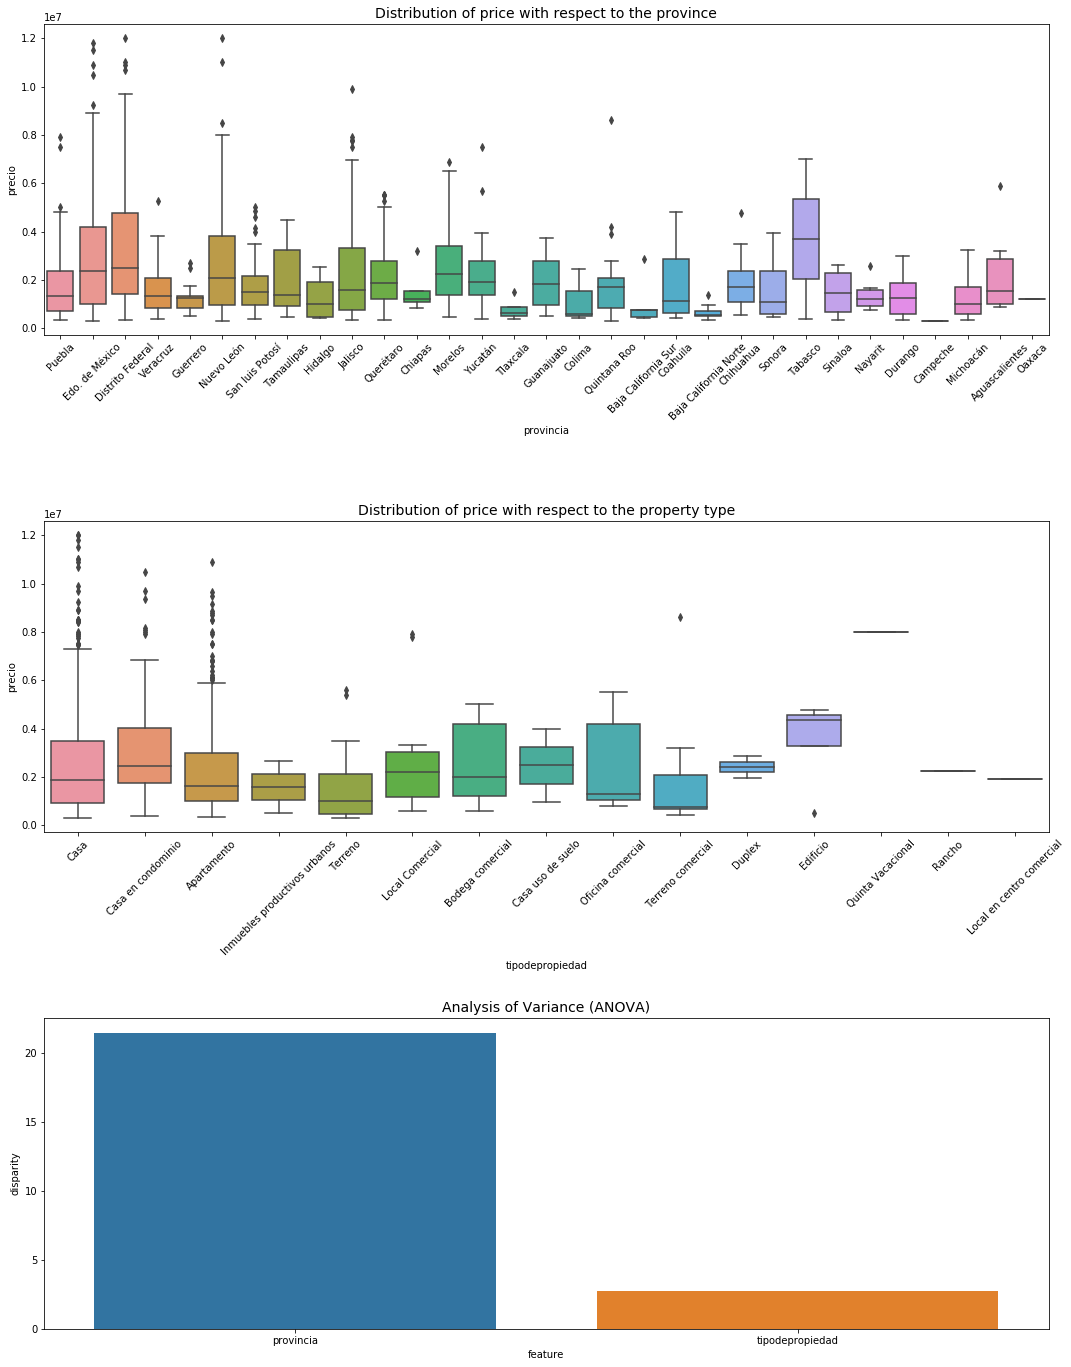

In [43]:
fig, ax = plt.subplots(figsize = [18,24], nrows = 3)
plt.subplots_adjust(hspace = 0.6)

ax[0].set_title('Distribution of price with respect to the province',fontsize = 14)
sns.boxplot(x= train['provincia'], y=train['precio'], ax = ax[0])
ax[0].tick_params(axis='x', rotation=45)

ax[1].set_title('Distribution of price with respect to the property type',fontsize = 14)
sns.boxplot(x= train['tipodepropiedad'], y=train['precio'], ax = ax[1])
ax[1].tick_params(axis='x', rotation=45)


ax[2].set_title('Analysis of Variance (ANOVA)', fontsize = 14)
sns.barplot(data=anova, x='feature', y='disparity', ax = ax[2])

plt.show()